<a href="https://colab.research.google.com/github/robson-rsp/datascience/blob/main/classification/twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contexto

##Análise de sentimentos

O conjunto de dados utilizado neste kernel contém twitts de pessoas a respeito do governo de Minas Gerais. O objetivo é treinar um modelo que faça uma análise de sentimentos desses twitts. Aqui, serão apresentadas diversas técnicas de tratamento de text, além de seleção de modelos, como:

*    Extração de hastags
*    Remoção de palavras precedidas por @,
*    Remoção de urls
*    Formatação de texto
*    Remoção de twitts duplicados
*    Codificação dos twitts

Fonte: https://raw.githubusercontent.com/stacktecnologias/stack-repo/master/Tweets_Mg.csv

# Imports iniciais

In [ ]:
%pip install -q -U urlextract
%pip install git+https://github.com/scikit-optimize/scikit-optimize.git -q
%pip install git+https://github.com/stanfordnlp/stanza.git
%pip install googletrans==3.1.0a0
%pip install pyarrow
%pip install transformers
%pip install unidecode
%pip install ipython-autotime --upgrade
%pip install matplotlib --upgrade
%pip install scikit-learn --upgrade

In [1]:
from google.colab import drive, files
import pandas as pd
import warnings

%load_ext autotime

warnings.filterwarnings("ignore")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.56 s (started: 2023-03-08 16:48:08 +00:00)


In [2]:
dataset = pd.read_csv("/content/drive/MyDrive/datasets/tweets_mg.csv", encoding='utf-8')

time: 217 ms (started: 2023-03-08 16:48:13 +00:00)


#EDA

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

time: 2.9 s (started: 2023-03-08 16:48:18 +00:00)


In [4]:
dataset.shape

(8199, 26)

time: 14 ms (started: 2023-03-08 16:48:23 +00:00)


In [5]:
dataset.head(5)

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador ...,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https:/...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sun Jan 08 01:01:46 +0000 2017,"�� @ Governador Valadares, Minas Gerais https:...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Wed Jan 04 21:43:51 +0000 2017,��� https://t.co/BnDsO34qK0,NaN,NaN,NaN,Ana estudando,estudandoconcur,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores ...,NaN,NaN,NaN,Emily,Milly777,0,Negativo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 158 ms (started: 2023-03-08 16:48:23 +00:00)


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8199 entries, 0 to 8198
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 8199 non-null   int64  
 1   Created At                 8199 non-null   object 
 2   Text                       8199 non-null   object 
 3   Geo Coordinates.latitude   104 non-null    float64
 4   Geo Coordinates.longitude  104 non-null    float64
 5   User Location              5489 non-null   object 
 6   Username                   8199 non-null   object 
 7   User Screen Name           8199 non-null   object 
 8   Retweet Count              8199 non-null   int64  
 9   Classificacao              8199 non-null   object 
 10  Observação                 1 non-null      object 
 11  Unnamed: 10                0 non-null      float64
 12  Unnamed: 11                0 non-null      float64
 13  Unnamed: 12                0 non-null      float

As duas células acima nos mostram há 26 colunas, mas as únicas que nos interessam são 'Text' e 'Classificacao'.

Positivo    3300
Neutro      2453
Negativo    2446
Name: Classificacao, dtype: int64 



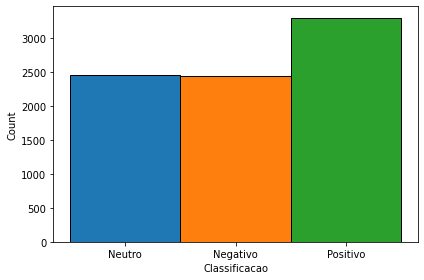

time: 302 ms (started: 2023-03-08 17:11:00 +00:00)


In [49]:
classes = dataset['Classificacao'].value_counts()
print(classes, '\n')
colors = sns.color_palette()

ax = sns.histplot(data=dataset, x='Classificacao', bins=3)
ax.patches[0].set_facecolor(colors[0])
ax.patches[1].set_facecolor(colors[1])
ax.patches[2].set_facecolor(colors[2])
plt.tight_layout()
plt.show()

Na sua forma original, o conjunto de dados apresenta um leve desequilíbrio de classes.

In [8]:
dataset[['Text', 'Classificacao']].isna().sum()

Text             0
Classificacao    0
dtype: int64

time: 8.19 ms (started: 2023-03-08 16:48:42 +00:00)


Não há nenhum valor ausente no conjunto considerando apenas as colunas 'Text' e 'Classificacao'.

In [9]:
dataset[dataset.duplicated()]

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


time: 37.7 ms (started: 2023-03-08 16:48:43 +00:00)


Analisando mais atentamente a coluna 'Text' é possível ver que a função duplicated() não funciona da maneira esperada. Alguns twits iguais não estão sendo identificados, por exemplo, os das linhas [1, 2], [13, 14], [17, 18, 19], entre outros. Minha solução para esse problema é fazer um processamento de texto inicial na coluna que consiste em:

* Colocar todas as letras em minúsculo;
* Remover links(tem que ser feito antes da remoção de pontuações pois esta acaba com a estrutura da url);
* Remover pontuações;
* Remover palavras sequidas por @.

Vou deixar acentuações por enquanto porque o código que usarei pode remover as hashtags e não quero isso pois vou mantê-las pois as palavras que as seguirem podem ser úteis na análise.

#Train/Test split

A primeira coisa a ser feita após uma análise exploratória seria separar o conjunto de dados em treinamento e teste, mas preciso remover os registros duplicados antes. Então, vou limpar os dados da coluna 'Text' para que eu possa fazer as remoções.

#Feature engineering

In [10]:
from difflib               import SequenceMatcher
from nltk.corpus           import stopwords
from nltk.tokenize         import TweetTokenizer, word_tokenize
from sklearn.base          import BaseEstimator, TransformerMixin
from sklearn.compose       import ColumnTransformer
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from unidecode             import unidecode
import re
import nltk
import numpy as np
import stanza
import urlextract

nltk.download("stopwords")
stanza.download('pt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


INFO:stanza:Downloading default packages for language: pt (Portuguese) ...
INFO:stanza:File exists: /root/stanza_resources/pt/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


time: 7.58 s (started: 2023-03-08 16:49:11 +00:00)


A classe ColumnTransformer retorna por padrão um numpy array, mas para gerenciar melhor os atributos que passarão por transformações através de um pipeline, prefiro que ela retorne sempre um objeto DataFrame do Pandas. O problema é que este vem com os nomes das colunas alterados, então resolvi criar a classe abaixo para atribuir ao DataFrame que saiu do ColumnTransformer os nomes originais.

In [11]:
class FeaturesRenamer(BaseEstimator, TransformerMixin):
    """
    Esta classe deve ser colocada diretamente dentro de um Pipeline.
    Quando 'get_feature_names_out()' é chamado ele concatena o nome do transformador ao nome de cada coluna
    que passará pela transformação. Esta classe desfaz isso retornando os nomes originais.
    """
    def __init__(self, original_names):
        if isinstance(original_names, list):
            self.original_names = original_names
        else:
            self.original_names = list(original_names)
    
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    
    def transform(self, X, y=None):
        new_names = list()
        for name in list(X.columns):
            for original in self.original_names:
                if name.endswith('__' + original):
                    new_names.append(original)
        return X.set_axis(new_names, axis=1)

time: 3.08 ms (started: 2023-03-08 16:49:34 +00:00)


## Limpeza dos twitts.

As transformações que farei através de classes personalizadas não trarão prejuízo ao modelo se feitas no conjunto de dados completo. Digo isso porque não há nenhuma informação como, cálculo de média ou mediana que possa 'vazar' para o conjunto de teste. Por isso posso usar fit_transform(train) e transform(test) sem me preocupar com 'data leak'.

**Etapa ## - Reformulação do dataset:** As únicas colunas que me interessam são 'Text' e 'Classificacao'. O resto não importa na análise de sentimentos.

In [12]:
feat_names = ['Text', 'Classificacao']
dataset = dataset[feat_names]

time: 2.24 ms (started: 2023-03-08 16:49:57 +00:00)


**Etapa ## - Extração de hashtags:** Podem ser úteis na tarefa.

In [13]:
class HashtagExtractor(BaseEstimator, TransformerMixin):
  """
  Identifica tokens precedidos por # e os separa da string.
  Retorna uma nova string sem os tokens e eles mesmos.
  """
  def __init__(self):
    self.tk = TweetTokenizer()
    self.twitts = list()
    self.hashtags = list()

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)
  
  def get_feature_names_out(self):
      pass

  def hashtag_extractor(self, twitt):
    tokens = self.tk.tokenize(twitt)
    hashtags = ''
    for tk in tokens:
      if (tk.startswith('#')) and (len(tk) > 1):
        hashtags += ' ' + tk
        twitt = twitt.replace(tk, '')
    if hashtags == '':
      hashtags = None
    self.twitts.append(twitt)
    self.hashtags.append(hashtags)
  
  def transform(self, X, y=None):
    for index, series in X.iterrows():
      self.hashtag_extractor(series['Text'])
    X['Text'] = self.twitts
    X['Hashtag'] = self.hashtags
    X['Hashtag'] = X['Hashtag'].str.lower()
    return X



ct_hashtag_extractor = ColumnTransformer(transformers=[('hashtag_extractor', HashtagExtractor(), ['Text'])], remainder='passthrough')
ct_hashtag_extractor.set_output(transform='pandas')

feat_names.extend(['Hashtag'])

time: 9.69 ms (started: 2023-03-08 16:50:04 +00:00)


**Etapa ## - Remoções variadas:** Encapsularei em uma classe várias remoções que considero úteis para essa tarefa:

*   @...
*   nomes próprios (deixei aqui apenas para registro porque não ajudou em nada)
*   urls
*   acentuação
*   pontuação
*   stopwords (pode ser útil caso use ngrams(2, 2) ou maiores.


In [14]:
class ElementsRemover(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.stz = stanza.Pipeline(lang='pt', verbose=False)
    self.sw  = set(stopwords.words("portuguese"))
    self.tk  = TweetTokenizer()
    self.ue  = urlextract.URLExtract()

  def at_rt_remover(self, twitt):
    """
    Remove tokens precedidos por @ e as letras 'RT'.
    """
    tokens = self.tk.tokenize(twitt)
    for tk in tokens:
      if (tk.startswith('@')) and (len(tk) > 1):
        twitt = twitt.replace(tk, '')
      if tk.startswith('RT') and len(tk) <= 3: # tenta remover 'RT:' caso caso contrário só remove o 'RT'.
        twitt = twitt.replace(tk, '')
    return twitt

  def fit(self, X, y=None):
    return self
  
  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def get_feature_names_out(self):
      pass

  def propn_remover(self, sentence):
    """
    Remove tokens identificados como nomes próprios(PROPN).
    """
    sentence_tks = self.stz(sentence).sentences[0].tokens
    s = ''
    for sentence in self.stz(sentence).sentences:
      for token in sentence.tokens:
        t = token.to_dict()[0]
        try: # nem todos os tokens possuem certas chaves, como 'upos'
          if t['upos'] != 'PROPN':
            s += ' ' + t['text']
        except KeyError:
          s += ' ' + t['text']
    return s

  def punctuation_remover(self, twitt):
    return re.sub('[^a-zA-Z]', ' ', twitt)

  def stopwords_remover(self, twitt):
    twitt_tokenized =  self.stz(twitt).sentences
    if not twitt_tokenized:
      return ''
    sentence = twitt_tokenized[0]
    s = ''
    for token in sentence.tokens:
      t = token.to_dict()[0]
      try: # nem todos os tokens possuem certas chaves, como 'upos'
        if t['text'] not in self.sw:
          s += t['text'] + ' '
      except KeyError:
        s += ' '
    return s

  def transform(self, X, y=None):
    X = np.vectorize(self.at_rt_remover)(X)
    #X = np.vectorize(self.propn_remover)(X)
    X = np.vectorize(self.url_remover)(X)
    X = np.vectorize(unidecode)(X) # remove acentuação
    X = np.vectorize(self.punctuation_remover)(X) # remove pontuação
    #X = np.vectorize(self.stopwords_remover)(X)
    return pd.DataFrame(data=X, columns=['Text'])

  def url_remover(self, twitt):
    urls = list(set(self.ue.find_urls(twitt)))
    urls.sort(key=lambda url: len(url), reverse=True)
    for url in urls:
      twitt = twitt.replace(url, '')
    # remove urls incompletas não estavam sendo detectadas
    return re.sub('(https?://[^\s]+)', '', twitt)



ct_elements_remover = ColumnTransformer(transformers=[('elements_remover', ElementsRemover(), ['Text'])], remainder='passthrough')
ct_elements_remover.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('elements_remover', ElementsRemover(),
                                 ['Text'])])

time: 2.8 s (started: 2023-03-08 16:50:21 +00:00)


**Etapa ## - Formatações variadas:** Aqui também encapsulei algumas formatações de string úteis.
    
*   Todas as palavras devem conter apenas um espaço em branco.
*   Todos os twitts devem estar em letras minúsculas.

In [15]:
class TwittFormatter(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y=None):
    return self
  
  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def get_feature_names_out(self):
      pass

  def space_formatter(self, twitt):
    """
    Remove múltiplos espaços entre palavras deixando apenas um.
    Se a string for vazia, coloca np.nan no lugar.
    """
    twitt = ' '.join(twitt.split())
    twitt = twitt.strip()
    if twitt:
      return twitt
    else:
      return None

  def twitt_to_lower(self, twitt):
    return twitt.lower()

  def transform(self, X, y=None):
    X = np.vectorize(self.twitt_to_lower)(X)
    X = np.vectorize(self.space_formatter)(X)
    return pd.DataFrame(data=X, columns=['Text'])



ct_twitt_formatter = ColumnTransformer(transformers=[('twitt_formatter', TwittFormatter(), ['Text'])], remainder='passthrough')
ct_twitt_formatter.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('twitt_formatter', TwittFormatter(),
                                 ['Text'])])

time: 13.5 ms (started: 2023-03-08 16:50:29 +00:00)


**Etapa ## - Remoção de twitts duplicados:** A remoção é feita de duas maneiras, direta e indireta.

* Direta: usa a função pd.drop_duplicates()
* Indireta: primeiramente compara os twitts e aqueles que tiverem uma semelhança x serão considerados iguais sendo removidos também. 

Vou colocar essa classe diretamente dentro de um Pipeline porque ColumnTransformer espera que o DataFrame retornado tenha o mesmo número de linhas que aquele passado por argumento em fit_transform().

In [17]:
class DuplicatesRemover(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def match_similar(self, X, similarity=0.9):
    """
    Substitui duas frases muito parecidas pelas palavras que elas têm em comum. O nível de semelhança pode ser ajustável.
    """
    size = len(X)
    for i in range(size-1):
      for j in range(i+1, size):
        twitt_a = X.loc[i, 'Text']
        twitt_b = X.loc[j, 'Text']
        sm = SequenceMatcher(None, twitt_a, twitt_b).ratio()
        if sm >= similarity:
          words_a = set(twitt_a.split(' '))
          words_b = set(twitt_b.split(' '))
          intersec = words_a.intersection(words_b)
          X.loc[i, 'Text'] = ' '.join(intersec)
          X.loc[j, 'Text'] = ' '.join(intersec)
    return X

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def get_feature_names_out(self):
      pass

  def remove_duplicates(self, X):
    X = X.sort_values(by=['Text'])
    X = X.drop_duplicates(subset=['Text']) # Por causa dessa função o pipeline levou 42min de processamento no google colab.
    X = X.reset_index().drop('index', axis=1)
    return X

  def transform(self, X, y=None):
    X = self.remove_duplicates(X)
    X = self.match_similar(X, similarity=0.9)
    X = self.remove_duplicates(X)
    return pd.DataFrame(data=X, columns=['Text', 'Classificacao', 'Hashtag'])



pp_duplicates_remover = Pipeline(steps=[('duplicates_remover', DuplicatesRemover())])

time: 4.4 ms (started: 2023-03-08 16:50:55 +00:00)


**Etapa ## - Recuperação das hashtags:** Concatena as hashtags com os seus respectivos twitts e remove a coluna 'Hashtag' do conjunto de dados.

In [18]:
class HashtagRecover(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def get_feature_names_out(self):
      pass

  def transform(self, X, y=None):
    twitts = X.loc[:, 'Text']
    hashtags = X.loc[:, 'Hashtag']
    twitts = np.vectorize(self.twitt_hashtag_concat)(twitts, hashtags)
    return pd.Series(data=twitts, name='Text') # a remoção da coluna 'Hashtag' é implícita uma vez que estou retornando apenas os twitts.

  def twitt_hashtag_concat(self, twitt, hashtag):
    if (twitt is None) and (hashtag is None):
      return None
    elif (twitt is not None) and (hashtag is None):
      return twitt
    elif (twitt is None) and (hashtag is not None):
      return hashtag
    else:
      return twitt + ' ' + hashtag[1:] #ignora o #



ct_hashtag_recover = ColumnTransformer(transformers=[('hashtag_recover', HashtagRecover(), ['Text', 'Hashtag'])], remainder='passthrough')
ct_hashtag_recover.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('hashtag_recover', HashtagRecover(),
                                 ['Text', 'Hashtag'])])

time: 70.9 ms (started: 2023-03-08 16:51:04 +00:00)


##Codificação da label

**OrdinalEncoder:** Tanto CountVectorizer quanto TfidfVectorizer não transformam a label em números por isso vou fazer separadamente.

In [19]:
ct_ordinal_encoder = ColumnTransformer(transformers=[('ordinal_encoder', OrdinalEncoder(), ['Classificacao'])], remainder='passthrough')
ct_ordinal_encoder.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinal_encoder', OrdinalEncoder(),
                                 ['Classificacao'])])

time: 8.02 ms (started: 2023-03-08 16:51:09 +00:00)


**Etapa final** - Pipeline completo de limpeza dos twitts:

In [ ]:
steps = [('hashtag_extractor', ct_hashtag_extractor),
         ('renamer01',    FeaturesRenamer(feat_names)),
         ('elements_remover', ct_elements_remover),
         ('renamer02',    FeaturesRenamer(feat_names)),
         ('twitt_formatter', ct_twitt_formatter),
         ('renamer03',    FeaturesRenamer(feat_names)),
         ('duplicates_remover', pp_duplicates_remover),
         ('hashtag_recover', ct_hashtag_recover),
         ('renamer04',    FeaturesRenamer(feat_names)),
         ('label_encoder',     ct_ordinal_encoder),
         ('renamer05',         FeaturesRenamer(feat_names)),]

pipeline_clean_up = Pipeline(steps=steps)
dataset_clean = pipeline_clean_up.fit_transform(dataset)

time: 42min 1s (started: 2023-03-07 00:57:37 +00:00)


Agora, posso considerar 'dataset_clean' como sendo o meu principal. Tudo o que preciso fazer é:


1.   Separar o conjunto de dados em conjunto de treinamento e teste.
2.   Codificar o atributo 'Text'.
3.   Selecionar e treinar os modelos.



#Train/Test split

In [22]:
from sklearn.model_selection import StratifiedKFold

time: 630 µs (started: 2023-03-08 16:51:37 +00:00)


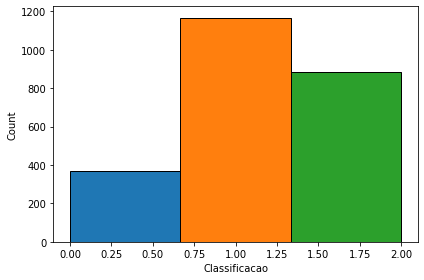

time: 1.54 s (started: 2023-03-08 17:01:55 +00:00)


In [33]:
colors = sns.color_palette()
ax = sns.histplot(data=dataset_clean, x='Classificacao', bins=3)
ax.patches[0].set_facecolor(colors[0])
ax.patches[1].set_facecolor(colors[1])
ax.patches[2].set_facecolor(colors[2])
plt.tight_layout()
plt.show()

O desequilíbrio de classes parece mais acentuado agora. Por isso, fazer uma amostragem estratificada que vai preservar as proporções de classes no conjunto de treinamento e teste. Depois, posso utilizar alguma técnica para reequilibrar o conjunto de treinamento.

In [34]:
skf = StratifiedKFold()
folds = skf.split(dataset_clean, dataset_clean['Classificacao'])
train_indexes, test_indexes = next(folds) # só o primeiro fold me interessa
X_train = dataset_clean.loc[train_indexes, 'Text']
y_train = dataset_clean.loc[train_indexes, 'Classificacao']
X_test  = dataset_clean.loc[test_indexes, 'Text']
y_test  = dataset_clean.loc[test_indexes, 'Classificacao']

time: 8.25 ms (started: 2023-03-08 17:02:12 +00:00)


#Codificação do conjunto de dados

Esta etapa ainda faz parte da engenharia de atributos, mas devido ao adiamento da separação de conjunto de treino e teste, resolvi fazer essa tarefa aqui.

In [35]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

time: 790 µs (started: 2023-03-08 17:02:14 +00:00)


##CountVectorizer

In [37]:
cv = CountVectorizer()

bag_of_words = cv.fit_transform(X_train)
X_train_cv = pd.DataFrame(data=bag_of_words.toarray(), columns=cv.get_feature_names_out())

bag_of_words = cv.transform(X_test)
X_test_cv = pd.DataFrame(data=bag_of_words.toarray(), columns=cv.get_feature_names_out())

time: 299 ms (started: 2023-03-08 17:02:18 +00:00)


##TfidfVectorizer

In [38]:
tfidf = TfidfVectorizer()
bag_of_words = tfidf.fit_transform(X_train)
X_train_tfidf = pd.DataFrame(data=bag_of_words.toarray(), columns=tfidf.get_feature_names_out())

bag_of_words = tfidf.transform(X_test)
X_test_tfidf = pd.DataFrame(data=bag_of_words.toarray(), columns=tfidf.get_feature_names_out())

time: 202 ms (started: 2023-03-08 17:02:23 +00:00)


#FeatureSelection

In [39]:
from sklearn.feature_selection import chi2, f_classif, SelectPercentile

time: 79 ms (started: 2023-03-08 17:02:30 +00:00)


Como o conjunto de treinamento e teste tem muitas dimensões, vou reduzi-las utilizando SelectPercentile. Esta classe vai selecionar 80% dos atributos mais importantes. O critério de importância será definido pelo teste estatístico ANOVA implementado pela função f_classif.

In [40]:
percentile = 80
select_percentile = SelectPercentile(score_func=f_classif, percentile=percentile)
best_features = select_percentile.fit(X_train_cv, y_train)
condition_mask = best_features.get_support()
X_train_cv = X_train_cv[X_train_cv.columns[condition_mask]]
X_test_cv  = X_test_cv[X_train_cv.columns]

select_percentile = SelectPercentile(score_func=f_classif, percentile=percentile)
best_features = select_percentile.fit(X_train_tfidf, y_train)
condition_mask = best_features.get_support()
X_train_tfidf = X_train_tfidf[X_train_tfidf.columns[condition_mask]]
X_test_tfidf  = X_test_tfidf[X_train_tfidf.columns]

time: 537 ms (started: 2023-03-08 17:02:30 +00:00)


# Resample

Muitas linhas foram apagadas ao fazer a eliminação de twitts duplicados, por isso vou fazer uma sobre amostragem dos dados para não eliminar ainda mais registros.

In [41]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

time: 421 ms (started: 2023-03-08 17:05:49 +00:00)


In [42]:
smote = SMOTE()
X_train_cv, y_train_cv       = smote.fit_resample(X_train_cv, y_train)
X_train_tfidf, y_train_tfidf = smote.fit_resample(X_train_tfidf, y_train)

time: 3.1 s (started: 2023-03-08 17:05:53 +00:00)


# Model training

In [43]:
from googletrans                   import Translator
from keras.wrappers.scikit_learn   import KerasClassifier
from sklearn.dummy                 import DummyClassifier
from sklearn.ensemble              import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model          import SGDClassifier
from sklearn.metrics               import classification_report, confusion_matrix
from sklearn.model_selection       import cross_val_score, RandomizedSearchCV
from sklearn.svm                   import SVC
from skopt                         import BayesSearchCV
from tensorflow.keras.models       import Sequential
from tensorflow.keras.layers       import Dense, Dropout, InputLayer
from tensorflow.keras.callbacks    import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers   import Nadam
from tensorflow.keras.regularizers import l1_l2
from transformers                  import AutoTokenizer, AutoModelForSequenceClassification
from transformers.models.reformer.modeling_reformer import ReformerForSequenceClassification

time: 6.13 s (started: 2023-03-08 17:06:00 +00:00)


Nesta fase, vou testar dois modelos de cada categoria.

*   Lineares: SGDClassifier, SupportVectorClassifier
*   Baseados em árvores: RandomForestClassifier, ExtraTreesClassifier
*   Redes neurais: Rede Neural, BERT

Primeiro, vou avaliar o desempenho deles em uma validação cruzada sem qualquer ajuste de hiper parâmetros. Farei os ajustes naqueles mais promissores. Por último, escolherei o que apresentar melhor resultado no cojunto de teste.

Como reequilibrei os conjuntos, posso confiar na métrica 'acurácia', apesar de já ser esperado um desempenho pior dos modelos no conjunto de teste porque este não foi reequilibrado.


##Baseline model

In [44]:
dc = DummyClassifier(strategy='stratified')
result = dc.fit(X_train_tfidf, y_train_tfidf)
y_pred = dc.predict(X_train_tfidf)
print(classification_report(y_train_tfidf, y_pred))

              precision    recall  f1-score   support

         0.0       0.31      0.32      0.31       934
         1.0       0.31      0.31      0.31       934
         2.0       0.34      0.33      0.33       934

    accuracy                           0.32      2802
   macro avg       0.32      0.32      0.32      2802
weighted avg       0.32      0.32      0.32      2802

time: 27.2 ms (started: 2023-03-08 17:09:09 +00:00)


## SGDClassifier

In [45]:
result = cross_val_score(SGDClassifier(random_state=42), X_train_tfidf, y_train_tfidf, cv=5, scoring='accuracy')
print(f'tfidf - Mean accuracy: {result.mean()}')

tfidf - Mean accuracy: 0.9479055258467024
time: 7.68 s (started: 2023-03-08 17:09:19 +00:00)


In [46]:
result = cross_val_score(SGDClassifier(random_state=42), X_train_cv, y_train_cv, cv=5, scoring='accuracy')
print(f'cv - Mean accuracy: {result.mean()}')

cv - Mean accuracy: 0.8326324166030048
time: 17.4 s (started: 2023-03-08 17:09:29 +00:00)


## SupportVectorClassifier

In [50]:
result = cross_val_score(SVC(random_state=42), X_train_tfidf, y_train_tfidf, cv=5, scoring='accuracy')
print(f'tfidf - Mean accuracy: {result.mean()}')

tfidf - Mean accuracy: 0.9404227145403616
time: 2min 9s (started: 2023-03-08 17:11:46 +00:00)


In [51]:
result = cross_val_score(SVC(random_state=42), X_train_cv, y_train_cv, cv=5, scoring='accuracy')
print(f'cv - Mean accuracy: {result.mean()}')

cv - Mean accuracy: 0.8476604278074866
time: 1min 42s (started: 2023-03-08 17:13:59 +00:00)


## RandomForestClassifier

In [ ]:
result = cross_val_score(RandomForestClassifier(random_state=42), X_train_tfidf, y_train_tfidf, cv=5, scoring='accuracy')
print(f'tfidf - Mean accuracy: {result.mean()}')

tfidf - Mean accuracy: 0.9204462694168578
time: 14.6 s (started: 2023-03-07 23:48:13 +00:00)


In [ ]:
result = cross_val_score(RandomForestClassifier(random_state=42), X_train_cv, y_train_cv, cv=5, scoring='accuracy')
print(f'cv - Mean accuracy: {result.mean()}')

cv - Mean accuracy: 0.8376324166030049
time: 19.5 s (started: 2023-03-07 23:48:28 +00:00)


##ExtraTreesClassifier

In [ ]:
result = cross_val_score(ExtraTreesClassifier(random_state=42), X_train_tfidf, y_train_tfidf, cv=5, scoring='accuracy')
print(f'tfidf - Mean accuracy: {result.mean()}')

tfidf - Mean accuracy: 0.9339985994397759
time: 22.7 s (started: 2023-03-07 23:50:49 +00:00)


In [ ]:
result = cross_val_score(ExtraTreesClassifier(random_state=42), X_train_cv, y_train_cv, cv=5, scoring='accuracy')
print(f'cv - Mean accuracy: {result.mean()}')

cv - Mean accuracy: 0.8479806468041764
time: 24.8 s (started: 2023-03-07 23:51:12 +00:00)


## BERT

Tentei usar um modelo neural pronto disponível no site huggingface, mas primeiro, precisava traduzir os twitts para inglês, que é o idioma no qual ele foi treinado. 

Não deu certo! O resultado foi pouca coisa melhor que o DummyClassifier.

In [ ]:
# base url - https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment
# https://www.youtube.com/watch?v=szczpgOEdXs
# https://www.youtube.com/watch?v=QpzMWQvxXWk
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

time: 19.1 s (started: 2023-03-08 00:01:45 +00:00)


In [ ]:
translator = Translator()
twitts_eng = list()

for twitt in dataset_clean['Text'].to_numpy():
  twitts_eng.append(translator.translate(twitt).text)

time: 5min 7s (started: 2023-03-08 00:03:01 +00:00)


In [ ]:
y_pred_ = list()
for twitt in twitts_eng:
  tokens = tokenizer.encode(twitt, return_tensors='pt')
  result = model(tokens)
  y_pred_.append(np.argmax(result.logits.detach().numpy()))

time: 6min 45s (started: 2023-03-08 00:08:45 +00:00)


In [ ]:
print(classification_report(dataset_clean['Classificacao'], y_pred_))

              precision    recall  f1-score   support

         0.0       0.24      0.46      0.31       368
         1.0       0.48      0.64      0.55      1168
         2.0       0.22      0.04      0.07       884

    accuracy                           0.39      2420
   macro avg       0.31      0.38      0.31      2420
weighted avg       0.35      0.39      0.34      2420

time: 34.9 ms (started: 2023-03-08 00:21:50 +00:00)


## Neural Network

In [38]:
nn = Sequential()
nn.add(InputLayer(input_shape=(X_train_tfidf.shape[1],)))
nn.add(Dense(units=9, kernel_initializer="lecun_normal", activation='sigmoid'))
nn.add(Dropout(rate=0.6))
nn.add(Dense(units=9, kernel_initializer="lecun_normal", activation='sigmoid'))
#nn.add(Dropout(rate=0.2))
nn.add(Dense(units=3, activation='softmax'))

time: 267 ms (started: 2023-03-08 16:22:51 +00:00)


In [39]:
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# performance scheduling
lr_performance = ReduceLROnPlateau(factor=0.3, patience=10)

time: 1.11 ms (started: 2023-03-08 16:22:55 +00:00)


In [40]:
nn.compile(loss='sparse_categorical_crossentropy', optimizer=Nadam(learning_rate=0.001), metrics=["accuracy"])

history = nn.fit(X_train_tfidf, y_train_tfidf, 
                 validation_split=0.2, epochs=50, 
                 callbacks=[early_stopping_cb, lr_performance], verbose=False)

y_pred = nn.predict(X_train_tfidf)
print(classification_report(y_train_tfidf, y_pred.argmax(axis=1)))

88/88 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       934
         1.0       0.94      0.97      0.95       934
         2.0       0.99      0.96      0.97       934

    accuracy                           0.97      2802
   macro avg       0.97      0.97      0.97      2802
weighted avg       0.97      0.97      0.97      2802

time: 46.5 s (started: 2023-03-08 16:22:57 +00:00)


In [23]:
y_pred = nn.predict(X_test_tfidf)
print(classification_report(y_test, y_pred.argmax(axis=1)))

16/16 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.82      0.81      0.82        74
         1.0       0.86      0.95      0.90       234
         2.0       0.99      0.85      0.92       176

    accuracy                           0.89       484
   macro avg       0.89      0.87      0.88       484
weighted avg       0.90      0.89      0.89       484

time: 145 ms (started: 2023-03-08 13:51:11 +00:00)


#Best models hyperparameter optimization

Os modelos mais promissores são:

1.   Neural Network: 0.99
2.   SDGClassifier: 0.94
3.   ExtraTreesClassifier: 0.93

Para o ajuste de hiper-parâmetros vou usar a classe BayesSearchCV pois RandomizedSearchCV eu já use em outro kernel.

Além disso, os melhores desempenhos foram usando o conjunto de dados codificado usando a técnica 'tf-idf'.

##SDGClassifier

In [30]:
params = {'loss': ['log'],
          'penalty': ['l2', 'elasticnet'],
          'alpha': np.arange(0.0001, 0.1, 0.001),
          'learning_rate': ['constant', 'optimal', 'invscaling'],
          'eta0': np.arange(0.0001, 0.1, 0.001),
          'early_stopping': [False, True],}

bs_cv = BayesSearchCV(SGDClassifier(), params, scoring='accuracy', cv=5, n_iter=50, verbose=False)
bs_cv.fit(X_train_tfidf, y_train_tfidf)
sgd_best = bs_cv.best_estimator_
sgd_best

SGDClassifier(alpha=0.0011, eta0=0.0471, learning_rate='constant', loss='log',
              penalty='elasticnet')

time: 9min 51s (started: 2023-03-08 14:20:40 +00:00)


In [31]:
history = sgd_best.fit(X_train_tfidf, y_train_tfidf)
y_pred = sgd_best.predict(X_train_tfidf)
print(classification_report(y_train_tfidf, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.87      0.90       934
         1.0       0.81      0.92      0.86       934
         2.0       0.97      0.89      0.93       934

    accuracy                           0.89      2802
   macro avg       0.90      0.89      0.89      2802
weighted avg       0.90      0.89      0.89      2802

time: 8.82 s (started: 2023-03-08 14:35:28 +00:00)


In [32]:
y_pred = sgd_best.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.89      0.81        74
         1.0       0.88      0.89      0.88       234
         2.0       0.96      0.86      0.91       176

    accuracy                           0.88       484
   macro avg       0.86      0.88      0.87       484
weighted avg       0.89      0.88      0.88       484

time: 65.2 ms (started: 2023-03-08 14:35:43 +00:00)


##ExtraTreesClassifier

In [34]:
params = {'n_estimators': np.arange(100, 1100, 100),
          'criterion': ['gini', 'entropy'],
          'max_depth': np.arange(10, 110, 10),
          'min_samples_split': np.arange(2, 10, 2),
          'min_samples_leaf': np.arange(1, 8, 2),
          'max_features': ['sqrt', 'log2'],
          'max_leaf_nodes': np.arange(10, 60, 10),
          'bootstrap': [True],
          'oob_score': [False, True],
          'max_samples': np.arange(0.0, 1.0, 0.1),}

rs = BayesSearchCV(ExtraTreesClassifier(), params, scoring='accuracy', n_iter=30, cv=5, verbose=False)
rs.fit(X_train_tfidf, y_train_tfidf)
et_best = rs.best_estimator_

et_best

Best parameters are: OrderedDict([('bootstrap', True), ('criterion', 'gini'), ('max_depth', 50), ('max_features', 'log2'), ('max_leaf_nodes', 30), ('max_samples', 0.30000000000000004), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 900), ('oob_score', False)])

time: 26min 1s (started: 2023-03-08 15:09:08 +00:00)


In [53]:
et_best.fit(X_train_tfidf, y_train_tfidf)
y_pred  = et_best.predict(X_train_tfidf)
print(classification_report(y_train_tfidf, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       934
         1.0       0.92      0.92      0.92       934
         2.0       0.96      0.94      0.95       934

    accuracy                           0.94      2802
   macro avg       0.94      0.94      0.94      2802
weighted avg       0.94      0.94      0.94      2802

time: 5.42 s (started: 2023-03-08 16:29:40 +00:00)


In [54]:
y_pred = et_best.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.85      0.79        74
         1.0       0.87      0.86      0.87       234
         2.0       0.92      0.87      0.89       176

    accuracy                           0.86       484
   macro avg       0.84      0.86      0.85       484
weighted avg       0.87      0.86      0.86       484

time: 302 ms (started: 2023-03-08 16:29:53 +00:00)


##Neural Network

O ajuste de hiper-parâmetros do modelo de redes neurais é extremamente lento, por isso preferi fazer manualmente algumas vezes. Se você ainda assim preferir fazer esse ajuste automático, pode usar o código abaixo.

In [ ]:
def create_model(nlayers, nneurons, activation, dropout, lr, l1, l2, input_shape, output_shape):
  optimizer   = Nadam(lr=lr)
  regularizer = l1_l2(l1=l1, l2=l2)                                                   
  model = Sequential()
  model.add(InputLayer(input_shape=input_shape))
  for _ in range(nlayers):
    model.add(Dense(nneurons, activation=activation, kernel_regularizer=regularizer))
    if dropout != 0:
      model.add(Dropout(dropout))
  model.add(Dense(output_shape, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'],)
  return model



model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=20, verbose=True)

time: 5.02 ms (started: 2023-03-08 01:21:19 +00:00)


In [ ]:
params = {'nlayers': [0, 1, 2],
          'nneurons': [5, 10],
          'activation': ['relu', 'sigmoid'],
          'dropout': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
          'lr': [0.01, 0.001, 0.0001],
          'l1': [0, 0.01, 0.003, 0.001, 0.0001],
          'l2': [0, 0.01, 0.003, 0.001, 0.0001],
          'input_shape': [X_train_tfidf.shape[1]],
          'output_shape': [3]}

bs = BayesSearchCV(model, params, cv=5, n_iter=50, scoring='accuracy', random_state=42, verbose=False)
history = bs.fit(X_train_tfidf, y_train_tfidf, verbose=False)
best_rseach = bs.best_estimator_

#Resultado

Todos eles tiveram um desempenho pior no conjunto de teste. Isso se deve ao fato de que este conjunto está desequilibrado, portanto o resultado é esperado. Por este motivo escolhi a o modelo de rede neural como oficial para esta tarefa. Ele atingiu uma acurácia de 0.97 no conjunto de treinamento e 0.89 no conjunto de teste.